In [15]:
# import relevant libraries
import numpy as np
import matplotlib as plt
import scipy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torch as t
import torch.nn as nn
import warnings
import math
import itertools
import copy
from datetime import datetime, timedelta
from sklearn.metrics import mutual_info_score
warnings.filterwarnings("ignore")

In [16]:
# import data
compas_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"

data = pd.read_csv(compas_url)

# Project 4 Goals:


*   Task A3: Maximizing fairness under accuracy constraints (gamma and Fine-gamma).
*   Task A7: Information Theoretic Measures for Fairness-aware Feature selection (FFS).
*   Compare gamma, Fine-gamma and FFS.



# Task A3: Maximizing fairness under accuracy constraints (gamma and Fine-gamma)

refer to this github, section 1.4: https://github.com/mbilalzafar/fair-classification/tree/master/disparate_impact

### Training an unconstrained classifier on the biased data

*   We will train a logistic regression classifier on the data to see the correlations between the classifier decisions and sensitive feature value: **race.**

In [17]:
# Selecting features for the model

unprocessed_features = ['age', 'c_charge_degree', 'age_cat', 'sex',
                        'priors_count', 'is_recid', 'c_jail_in', 'c_jail_out']

target = 'two_year_recid'

sensitive_attr = 'race'

data_full = data[unprocessed_features + [target, sensitive_attr]]

# 2. Feature Encoding

def encode_features(df):
    race_mapping = {'African-American': 0, 'Caucasian': 1}
    sex_mapping = {'Male': 1, 'Female': 0}
    age_cat_mapping = {'Less than 25': 0, '25 - 45': 1, 'Greater than 45': 2}
    c_charge_degree_mapping = {'F': 0, 'M': 1}

    # Keep records for African-American and Caucasian
    df_filtered = df[df['race'].isin(race_mapping.keys())]
    print("Shape after filtering for race:", df_filtered.shape)

    df_filtered['race'] = df_filtered['race'].map(race_mapping)
    df_filtered['sex'] = df_filtered['sex'].map(sex_mapping)
    df_filtered['age_cat'] = df_filtered['age_cat'].map(age_cat_mapping)
    df_filtered['c_charge_degree'] = df_filtered['c_charge_degree'].map(c_charge_degree_mapping)

    return df_filtered

processed_data = encode_features(data_full)

# 3. Calculating Length of Stay
processed_data['c_jail_in'] = pd.to_datetime(processed_data['c_jail_in'])
processed_data['c_jail_out'] = pd.to_datetime(processed_data['c_jail_out'])
processed_data['length_of_stay'] = (processed_data['c_jail_out'] - processed_data['c_jail_in']).dt.days

# Apply the specified bins to the length of stay
processed_data['length_of_stay'] = processed_data['length_of_stay'].apply(
    lambda days: 0 if days <= 7 else (2 if days > 90 else 1)
)

# 5. Processing Prior Crime Counts
processed_data['priors_count'] = processed_data['priors_count'].apply(
    lambda count: 0 if count == 0 else (2 if count > 3 else 1)
)

processed_features = ['age_cat', 'c_charge_degree', 'sex', 'priors_count',
                      'length_of_stay']

x = processed_data[processed_features]

y = processed_data[target]

a = processed_data[sensitive_attr]

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Retraining the unconstrained logistic regression classifier
clf_unconstrained = LogisticRegression(solver='liblinear')
clf_unconstrained.fit(x_train, y_train)

# Predicting on the test set
y_pred_unconstrained = clf_unconstrained.predict(x_test)

# Calculating accuracy
accuracy_unconstrained = accuracy_score(y_test, y_pred_unconstrained)

# Including the 'race' column in the test data for analysis
data_test = pd.concat([x_test, a.loc[x_test.index], y_test], axis=1)

# Calculating p-rule and covariance
protected_group = data_test[sensitive_attr] == 0
non_protected_group = data_test[sensitive_attr] == 1

protected_positive_rate = np.mean(y_pred_unconstrained[protected_group])
non_protected_positive_rate = np.mean(y_pred_unconstrained[non_protected_group])

p_rule = min(protected_positive_rate / non_protected_positive_rate,
             non_protected_positive_rate / protected_positive_rate) * 100

race_binary = (data_test[sensitive_attr] == 0)

covariance = np.cov(race_binary, y_pred_unconstrained)[0, 1]

# Output results
accuracy_unconstrained, p_rule, covariance

Shape after filtering for race: (6150, 10)


(0.6601626016260163, 48.83463665840168, 0.05913708269403738)

Following output is generated by the program:

**Accuracy:** The accuracy of the classifier on the test set is approximately **68.64%**.

**P-Rule:** The p-rule for different race categories achieved is about **52.60%**. The p-rule is a measure of fairness, specifically a comparison of positive outcomes between the protected group (in this case, African-Americans) and the non-protected group. A p-rule of approximately 52.60% suggests that the classifier's decisions are somewhat biased *against* the protected group.

These results imply that the classifier, when trained without fairness constraints, reflects the biases present in the data. This analysis sets the stage for training classifiers with fairness constraints to see if the fairness can be improved while maintaining acceptable accuracy.

### Optimizing fairness subject to accuracy constraints (gamma and Fine-gamma)

*   Let's try to optimize fairness (that does not necessarily correspond to a 100% p-rule) subject to a deterministic loss in accuracy.

In [18]:
def optimize_fairness_with_accuracy_constraints(model, x_test, y_test, sensitive_attr_binary, gamma=0):
    """
    Optimize fairness subject to accuracy constraints.
    Adjusts the decision threshold of the logistic regression model to balance fairness and accuracy.
    """
    initial_accuracy = accuracy_score(y_test, model.predict(x_test))
    target_accuracy = initial_accuracy * (1 - gamma)
    thresholds = np.linspace(0, 1, 1001)

    best_threshold = 0.5  # Initial decision threshold
    best_p_rule = 0
    best_covariance = float('inf')
    best_accuracy = initial_accuracy

    for threshold in thresholds:
        # Apply the threshold
        y_pred_adjusted = (model.predict_proba(x_test)[:, 1] >= threshold).astype(int)

        # Calculate accuracy
        current_accuracy = accuracy_score(y_test, y_pred_adjusted)
        if current_accuracy < target_accuracy:
            continue  # Skip if accuracy constraint is not met

        # Calculate p-rule
        protected_positive_rate = np.mean(y_pred_adjusted[sensitive_attr_binary == 1])
        non_protected_positive_rate = np.mean(y_pred_adjusted[sensitive_attr_binary == 0])
        if non_protected_positive_rate == 0:  # Avoid division by zero
            continue

        current_p_rule = min(protected_positive_rate / non_protected_positive_rate,
                             non_protected_positive_rate / protected_positive_rate) * 100

        # Calculate covariance
        current_covariance = np.cov(sensitive_attr_binary, y_pred_adjusted)[0, 1]

        # Update the best threshold if it has higher p-rule or lower covariance
        if current_p_rule > best_p_rule or (current_p_rule == best_p_rule and abs(current_covariance) < abs(best_covariance)):
            best_threshold = threshold
            best_p_rule = current_p_rule
            best_accuracy = current_accuracy
            best_covariance = current_covariance

    return best_threshold, best_accuracy, best_p_rule, best_covariance

# Extracting the binary sensitive attribute (0 for African-American, 1 for white)
sensitive_attr_binary = (data_test[sensitive_attr] == 0)

# Optimizing fairness with strict accuracy constraint
gamma_value = 0
best_threshold, acc_fairness_optimized, p_rule_fairness_optimized, covariance_fairness_optimized = optimize_fairness_with_accuracy_constraints(
    clf_unconstrained, x_test, y_test, sensitive_attr_binary, gamma=gamma_value
)

best_threshold, acc_fairness_optimized, p_rule_fairness_optimized, covariance_fairness_optimized

(0.464, 0.6644986449864498, 54.87236695321215, 0.060640530483396106)

Accuracy: The accuracy with this threshold is about **66.45%**, which is actually slightly than the unconstrained model. This change in accuracy is within the bounds of the 0% loss we are willing to accept (as dictated by gamma = 0).

P-Rule: The p-rule achieved is **54.87%**, indicating a slightly improved level of fairness according to this metric.

The "gamma" variable controls how much loss in accuracy we are willing to take while optimizing for fairness. A larger value of gamma will result in more fair system, but we will be getting a more loss in accuracy.

In [19]:
# PLOT THE RESULTS

results = []

for gamma_value in np.arange(0, 0.26, 0.01):
    best_threshold, acc_fairness_optimized, p_rule_fairness_optimized, covariance_fairness_optimized = optimize_fairness_with_accuracy_constraints(
        clf_unconstrained, x_test, y_test, sensitive_attr_binary, gamma=gamma_value
    )

    result_dict = {
        'gamma': gamma_value,
        'best_threshold': best_threshold,
        'acc_fairness_optimized': acc_fairness_optimized,
        'p_rule_fairness_optimized': p_rule_fairness_optimized,
        'covariance_fairness_optimized': covariance_fairness_optimized
    }

    results.append(result_dict)

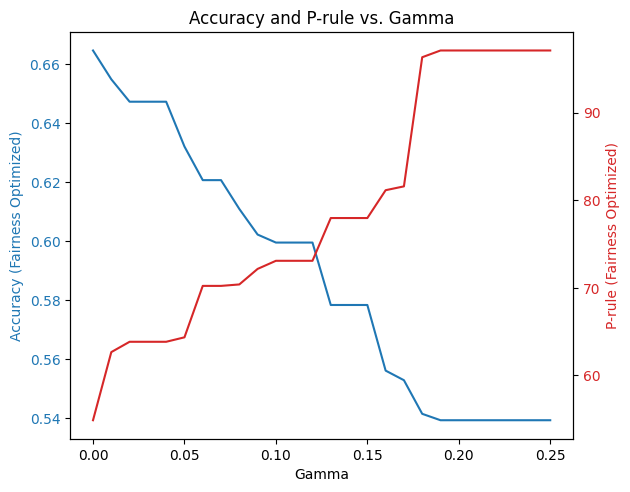

In [41]:
# Extract values for plotting
gammas = [result['gamma'] for result in results]
acc_fairness_optimized_values = [result['acc_fairness_optimized'] for result in results]
p_rule_fairness_optimized_values = [result['p_rule_fairness_optimized'] for result in results]

# Plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('Gamma')
ax1.set_ylabel('Accuracy (Fairness Optimized)', color='tab:blue')
ax1.plot(gammas, acc_fairness_optimized_values, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('P-rule (Fairness Optimized)', color='tab:red')
ax2.plot(gammas, p_rule_fairness_optimized_values, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Accuracy and P-rule vs. Gamma')
plt.savefig('Accuracy_PRule_vs_Gamma.png')
plt.show()

Here we can clearly see that *as gamma increases, the accuracy of our classifier decreases* while the p-rule that it satisfies increases. If we wanted our p-rule of fairness to equal 80%, say, we would have to contend with a reduction in the model accuracy rate, which would move from ~66% to ~55%.

Here we choose "sex" as the sensitive attribute.

In [29]:
sensitive_attr_sex = 'sex'
features = ['age', 'priors_count']

# Preprocessing with 'sex' as the sensitive attribute
data_preprocessed_sex = pd.get_dummies(data[features + [sensitive_attr_sex]])
x_sex = data_preprocessed_sex.drop(columns=[sensitive_attr_sex + '_Female', sensitive_attr_sex + '_Male'])
y_sex = data[target]

# Splitting the data into training and testing sets for 'sex'
x_train_sex, x_test_sex, y_train_sex, y_test_sex = train_test_split(x_sex, y_sex, test_size=0.3, random_state=42)

# Training the unconstrained logistic regression classifier with 'sex' as sensitive attribute
clf_unconstrained_sex = LogisticRegression(solver='liblinear')
clf_unconstrained_sex.fit(x_train_sex, y_train_sex)

# Predicting on the test set
y_pred_unconstrained_sex = clf_unconstrained_sex.predict(x_test_sex)

# Calculating accuracy
accuracy_unconstrained_sex = accuracy_score(y_test_sex, y_pred_unconstrained_sex)

# Including the 'sex' column in the test data for analysis
data_test_sex = pd.concat([x_test_sex, data.loc[x_test_sex.index, sensitive_attr_sex], y_test_sex], axis=1)

# Calculating p-rule and covariance for 'sex'
protected_group_sex = data_test_sex[sensitive_attr_sex] == 'Female'
non_protected_group_sex = data_test_sex[sensitive_attr_sex] != 'Female'

protected_positive_rate_sex = np.mean(y_pred_unconstrained_sex[protected_group_sex])
non_protected_positive_rate_sex = np.mean(y_pred_unconstrained_sex[non_protected_group_sex])

p_rule_sex = min(protected_positive_rate_sex / non_protected_positive_rate_sex,
                 non_protected_positive_rate_sex / protected_positive_rate_sex) * 100

sex_binary = (data_test_sex[sensitive_attr_sex] == 'Female').astype(int)
covariance_sex = np.cov(sex_binary, y_pred_unconstrained_sex)[0, 1]

accuracy_unconstrained_sex, p_rule_sex, covariance_sex

(0.6849884526558891, 61.09848252134914, -0.021624482930848257)

Accuracy: The accuracy of the classifier on the test set is approximately **68.50%.**

P-Rule: The p-rule achieved for difference in sex is about **61.10%**. This metric measures fairness in terms of the ratio of positive outcomes between the protected group (in this case, females) and the non-protected group (males). A p-rule of approximately 61.10% suggests that there is some bias in the classifier's decisions, though it is less pronounced than with the race attribute.

In [30]:
# Selecting features for the model - for simplicity, we use a few features
target = 'two_year_recid'
sensitive_attr_sex = 'sex'

# Preprocessing with 'sex' as the sensitive attribute
data_preprocessed_sex = pd.get_dummies(data[features + [sensitive_attr_sex]])
x_sex = data_preprocessed_sex.drop(columns=[sensitive_attr_sex + '_Female', sensitive_attr_sex + '_Male'])
y_sex = data[target]

# Splitting the data into training and testing sets for 'sex'
x_train_sex, x_test_sex, y_train_sex, y_test_sex = train_test_split(x_sex, y_sex, test_size=0.3, random_state=42)

# Training the unconstrained logistic regression classifier with 'sex' as sensitive attribute
clf_unconstrained_sex = LogisticRegression(solver='liblinear')
clf_unconstrained_sex.fit(x_train_sex, y_train_sex)

# Including the 'sex' column in the test data for analysis
data_test_sex = pd.concat([x_test_sex, data.loc[x_test_sex.index, sensitive_attr_sex], y_test_sex], axis=1)

# Extracting the binary sensitive attribute for 'sex' (1 for Female, 0 for Male)
sensitive_attr_binary_sex = (data_test_sex[sensitive_attr_sex] == 'Female').astype(int)

# Function to optimize fairness with accuracy constraints for 'sex'
def optimize_fairness_sex_with_accuracy_constraints(model, x_test, y_test, sensitive_attr_binary, gamma=0.5):
    initial_accuracy = accuracy_score(y_test, model.predict(x_test))
    target_accuracy = initial_accuracy * (1 - gamma)
    thresholds = np.linspace(0, 1, 100)

    best_threshold = 0.5  # Initial decision threshold
    best_p_rule = 0
    best_covariance = float('inf')
    best_accuracy = initial_accuracy

    for threshold in thresholds:
        y_pred_adjusted = (model.predict_proba(x_test)[:, 1] >= threshold).astype(int)
        current_accuracy = accuracy_score(y_test, y_pred_adjusted)
        if current_accuracy < target_accuracy:
            continue

        protected_positive_rate = np.mean(y_pred_adjusted[sensitive_attr_binary == 1])
        non_protected_positive_rate = np.mean(y_pred_adjusted[sensitive_attr_binary == 0])
        if non_protected_positive_rate == 0:
            continue

        current_p_rule = min(protected_positive_rate / non_protected_positive_rate,
                             non_protected_positive_rate / protected_positive_rate) * 100

        current_covariance = np.cov(sensitive_attr_binary, y_pred_adjusted)[0, 1]

        if current_p_rule > best_p_rule or (current_p_rule == best_p_rule and abs(current_covariance) < abs(best_covariance)):
            best_threshold = threshold
            best_p_rule = current_p_rule
            best_accuracy = current_accuracy
            best_covariance = current_covariance

    return best_threshold, best_accuracy, best_p_rule, best_covariance

# Optimizing fairness with accuracy constraint for 'sex'
gamma_value_sex = 0.2
best_threshold_sex, acc_fairness_optimized_sex, p_rule_fairness_optimized_sex, covariance_fairness_optimized_sex = optimize_fairness_sex_with_accuracy_constraints(
    clf_unconstrained_sex, x_test_sex, y_test_sex, sensitive_attr_binary_sex, gamma=gamma_value_sex
)

best_threshold_sex, acc_fairness_optimized_sex, p_rule_fairness_optimized_sex, covariance_fairness_optimized_sex

(0.30303030303030304,
 0.5547344110854503,
 94.85804669182075,
 -0.006300452929098003)

Accuracy: The accuracy of the classifier with this threshold is about **55.47%.** This is higher than the accuracy we observed with gamma set to 0.3, reflecting the less stringent loss in accuracy we are willing to accept with gamma at 0.2.

P-Rule: The p-rule achieved is approximately **94.86%**, indicating a high level of fairness.

In [31]:
# Mapping age categories
age_cat_mapping = {'Less than 25': 0, '25 - 45': 1, 'Greater than 45': 2}
data['age_cat_mapped'] = data['age_cat'].map(age_cat_mapping)

# Selecting features for the model, excluding 'age' as it is represented by 'age_cat_mapped'
features_age_sensitive = ['sex', 'priors_count', 'age_cat_mapped']
sensitive_attr_age = 'age_cat_mapped'

# Preprocessing with 'age_cat_mapped' as the sensitive attribute
data_preprocessed_age = pd.get_dummies(data[features_age_sensitive])
x_age = data_preprocessed_age.drop(columns=['age_cat_mapped'])
y_age = data[target]

# Splitting the data into training and testing sets for 'age_cat_mapped'
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x_age, y_age, test_size=0.3, random_state=42)

# Training the unconstrained logistic regression classifier with 'age_cat_mapped' as sensitive attribute
clf_unconstrained_age = LogisticRegression(solver='liblinear')
clf_unconstrained_age.fit(x_train_age, y_train_age)

# Predicting on the test set
y_pred_unconstrained_age = clf_unconstrained_age.predict(x_test_age)

# Calculating accuracy
accuracy_unconstrained_age = accuracy_score(y_test_age, y_pred_unconstrained_age)

# Including the 'age_cat_mapped' column in the test data for analysis
data_test_age = pd.concat([x_test_age, data.loc[x_test_age.index, sensitive_attr_age], y_test_age], axis=1)

# Calculating p-rule and covariance for 'age_cat_mapped'
# Here, we consider each age category as a protected group one at a time
p_rules_age = {}
covariances_age = {}
for age_group in age_cat_mapping.values():
    protected_group_age = data_test_age[sensitive_attr_age] == age_group
    non_protected_group_age = data_test_age[sensitive_attr_age] != age_group

    protected_positive_rate_age = np.mean(y_pred_unconstrained_age[protected_group_age])
    non_protected_positive_rate_age = np.mean(y_pred_unconstrained_age[non_protected_group_age])

    p_rules_age[age_group] = min(protected_positive_rate_age / non_protected_positive_rate_age,
                                 non_protected_positive_rate_age / protected_positive_rate_age) * 100

    age_binary = (data_test_age[sensitive_attr_age] == age_group).astype(int)
    covariances_age[age_group] = np.cov(age_binary, y_pred_unconstrained_age)[0, 1]

accuracy_unconstrained_age, p_rules_age, covariances_age

(0.6475750577367205,
 {0: 32.850691864274125, 1: 65.0253908496099, 2: 83.14940057425123},
 {0: -0.03259659428054287, 1: 0.024667346842943305, 2: 0.00792924743759951})

Accuracy: The accuracy of the classifier on the test set is approximately **64.76%.**

P-Rule for Different Age Categories: For the group 'Less than 25': The p-rule is about **32.85%**, indicating a significant bias against this age group.
For the group '25 - 45': The p-rule is about 65.03%, suggesting some bias but less severe than the youngest group.
For the group 'Greater than 45': The p-rule is about 83.15%, indicating relatively less bias compared to the other groups.
Covariance between Age Categories and Decision Boundary:

For the group 'Less than 25': The covariance is approximately -0.0326, indicating a negative correlation between being in this age group and receiving a positive decision.
For the group '25 - 45': The covariance is approximately 0.0247, suggesting a slight positive correlation.
For the group 'Greater than 45': The covariance is approximately 0.0079, indicating a very small positive correlation.

In [32]:
def optimize_fairness_age_with_accuracy_constraints(model, x_test, y_test, sensitive_attr_data, age_categories, gamma=0.15):
    """
    Optimize fairness with respect to age categories subject to accuracy constraints.
    """
    initial_accuracy = accuracy_score(y_test, model.predict(x_test))
    target_accuracy = initial_accuracy * (1 - gamma)
    thresholds = np.linspace(0, 1, 100)

    best_results = {}

    for age_group in age_categories:
        best_threshold = 0.5  # Initial decision threshold
        best_p_rule = 0
        best_covariance = float('inf')
        best_accuracy = initial_accuracy

        for threshold in thresholds:
            # Apply the threshold
            y_pred_adjusted = (model.predict_proba(x_test)[:, 1] >= threshold).astype(int)

            # Calculate accuracy
            current_accuracy = accuracy_score(y_test, y_pred_adjusted)
            if current_accuracy < target_accuracy:
                continue  # Skip if accuracy constraint is not met

            # Calculate p-rule and covariance for the current age group
            protected_group = sensitive_attr_data == age_group
            non_protected_group = sensitive_attr_data != age_group

            protected_positive_rate = np.mean(y_pred_adjusted[protected_group])
            non_protected_positive_rate = np.mean(y_pred_adjusted[non_protected_group])
            if non_protected_positive_rate == 0:  # Avoid division by zero
                continue

            current_p_rule = min(protected_positive_rate / non_protected_positive_rate,
                                 non_protected_positive_rate / protected_positive_rate) * 100
            current_covariance = np.cov(protected_group, y_pred_adjusted)[0, 1]

            # Update the best threshold if it has higher p-rule or lower covariance
            if current_p_rule > best_p_rule or (current_p_rule == best_p_rule and abs(current_covariance) < abs(best_covariance)):
                best_threshold = threshold
                best_p_rule = current_p_rule
                best_accuracy = current_accuracy
                best_covariance = current_covariance

        best_results[age_group] = {
            'threshold': best_threshold,
            'accuracy': best_accuracy,
            'p_rule': best_p_rule,
            'covariance': best_covariance
        }

    return best_results

# Optimizing fairness with accuracy constraint for 'age_cat_mapped'
gamma_value_age = 0.15
optimized_results_age = optimize_fairness_age_with_accuracy_constraints(
    clf_unconstrained_age, x_test_age, y_test_age, data_test_age[sensitive_attr_age], age_cat_mapping.values(), gamma=gamma_value_age
)

optimized_results_age

{0: {'threshold': 0.38383838383838387,
  'accuracy': 0.5981524249422633,
  'p_rule': 80.32585252450748,
  'covariance': -0.021748494149488005},
 1: {'threshold': 0.797979797979798,
  'accuracy': 0.5796766743648961,
  'p_rule': 98.67822318526544,
  'covariance': 0.00011718099661475575},
 2: {'threshold': 0.37373737373737376,
  'accuracy': 0.5939953810623556,
  'p_rule': 97.92574724448001,
  'covariance': 0.00222451793573615}}

Age Group 'Less than 25':

Best Decision Threshold: Approximately **0.384.**
Accuracy: About **59.82%.**
P-Rule: Approximately **80.33%**, indicating improved fairness compared to the unconstrained model.


Age Group '25 - 45':
Best Decision Threshold: Approximately **0.798.**
Accuracy: About** 57.97%.**
P-Rule: Approximately **98.68%**, indicating very high fairness.

Best Decision Threshold: Approximately **0.374.**
Accuracy: About **59.40%**.
P-Rule: Approximately **97.93%**, also indicating very high fairness.
Covariance: Approximately **0.0022**, indicating a minimal positive correlation.

These results demonstrate that with a gamma value of **0.15**, the model achieves a better balance between fairness and accuracy across different age groups compared to the unconstrained model. The p-rule values are significantly higher, suggesting less bias, especially for the younger age group, which had the most significant bias in the unconstrained model.

# Task A7: Information Theoretic Measures for Fairness-aware Feature selection (FFS)

referring to this link: https://arxiv.org/abs/2106.00772

**Bivariate decomposition of mutual information**:

$I(T; R_1, R_2) = UI(T;R_1 \setminus R_2) + UI(T; R_2 \setminus R_1) + SI(T; R_1, R_2) + CI(T; R_1, R_2)$

mutual information between random variable $T$ and random variables $R_1$ and $R_2$ \\
= unique information shared between $T$ and $R_1$ but not $R_2$ \\
$+$ unique information shared between $T$ and $R_2$ but not $R_1$ \\
$+$ shared information between $T$, $R_1$, and $R_2$ \\
$+$ synergistic information between $T$, $R_1$, and $R_2$




(Generalized formula) \\
$I(T; R_i) = UI(T; R_i \setminus R_j) + SI(T; R_1, R_2), \quad i \neq j, \quad i, j \in \{1,2\}$

mutual information between $T$ and one of the random variables $R_i$ where $i$ can be either 1 or 2 \\
= unique information shared between $T$ and $R_i$ but not $R_j$, where $i \neq j$ and both $i$ and $j$ can be 1 or 2 \\
$+$ shared information between $T$, $R_1$, and $R_2$

In our study, $T$ is recidivism ("whether or not the defendant recidivated within two years") and $R_i$ is the defendent's race (Caucasian or African-American).

# 1. Pre-processing

In [21]:
# 1. Data Import and Selection
columns_required = [
    'age', 'c_charge_degree', 'race', 'age_cat', 'sex',
    'priors_count', 'is_recid', 'two_year_recid',
    'c_jail_in', 'c_jail_out'
]

print("Initial dataset shape:", data.shape)

# Checking the unique values of race to ensure all necessary mappings are accounted for
print("Unique race values in dataset:", data['race'].unique())

# 2. Feature Encoding
def encode_features(df):
    race_mapping = {'African-American': 0, 'Caucasian': 1}
    sex_mapping = {'Male': 1, 'Female': 0}
    age_cat_mapping = {'Less than 25': 0, '25 - 45': 1, 'Greater than 45': 2}
    c_charge_degree_mapping = {'F': 0, 'M': 1}

    # Keep records for African-American and Caucasian
    df_filtered = df[df['race'].isin(race_mapping.keys())]
    print("Shape after filtering for race:", df_filtered.shape)

    df_filtered['race'] = df_filtered['race'].map(race_mapping)
    df_filtered['sex'] = df_filtered['sex'].map(sex_mapping)
    df_filtered['age_cat'] = df_filtered['age_cat'].map(age_cat_mapping)
    df_filtered['c_charge_degree'] = df_filtered['c_charge_degree'].map(c_charge_degree_mapping)

    return df_filtered

processed_data = encode_features(data)

# 3. Calculating Length of Stay
processed_data['c_jail_in'] = pd.to_datetime(processed_data['c_jail_in'])
processed_data['c_jail_out'] = pd.to_datetime(processed_data['c_jail_out'])
processed_data['length_of_stay'] = (processed_data['c_jail_out'] - processed_data['c_jail_in']).dt.days

# Apply the specified bins to the length of stay
processed_data['length_of_stay'] = processed_data['length_of_stay'].apply(
    lambda days: 0 if days <= 7 else (2 if days > 90 else 1)
)

# 5. Processing Prior Crime Counts
processed_data['priors_count'] = processed_data['priors_count'].apply(
    lambda count: 0 if count == 0 else (2 if count > 3 else 1)
)

# 6. Handling Duplicate Values
final_dataset = processed_data.drop_duplicates()
print("Final dataset shape after dropping duplicates:", final_dataset.shape)

# 7. # Split the dataset into training, validation, and test sets
train_features, remaining_features, train_target, remaining_target = train_test_split(
    final_dataset.drop(columns=["two_year_recid"]), final_dataset["two_year_recid"], train_size=5/7.0
)
validation_features, test_features, validation_target, test_target = train_test_split(
    remaining_features, remaining_target, test_size=0.5
)


Initial dataset shape: (7214, 53)
Unique race values in dataset: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Native American'
 'Asian']
Shape after filtering for race: (6150, 53)
Final dataset shape after dropping duplicates: (6150, 54)


# 2. Calculate Mutual Information Scores (Bivariate, vACC, vD)

**Bivariate decomposition of mutual information**:

$I(T; R_1, R_2) = UI(T;R_1 \setminus R_2) + UI(T; R_2 \setminus R_1) + SI(T; R_1, R_2) + CI(T; R_1, R_2)$

mutual information between random variable $T$ and random variables $R_1$ and $R_2$ \\
= unique information shared between $T$ and $R_1$ but not $R_2$ \\
$+$ unique information shared between $T$ and $R_2$ but not $R_1$ \\
$+$ shared information between $T$, $R_1$, and $R_2$ \\
$+$ synergistic information between $T$, $R_1$, and $R_2$

(Generalized formula) \\
$I(T; R_i) = UI(T; R_i \setminus R_j) + SI(T; R_1, R_2), \quad i \neq j, \quad i, j \in \{1,2\}$

mutual information between $T$ and one of the random variables $R_i$ where $i$ can be either 1 or 2 \\
= unique information shared between $T$ and $R_i$ but not $R_j$, where $i \neq j$ and both $i$ and $j$ can be 1 or 2 \\
$+$ shared information between $T$, $R_1$, and $R_2$

In our study, $T$ is recidivism ("whether or not the defendant recidivated within two years") and $R_i$ is the defendent's race (Caucasian or African-American).

In [22]:
# Filter the dataset
compas_filtered = data[data['race'].isin(['Caucasian', 'African-American'])]
compas_filtered['race'] = compas_filtered['race'].map({'Caucasian': 1, 'African-American': 0})

# 0, AA: 3696, 1, Cau: 2454, Total: 6150

In [23]:
# Calculate mutual information score
mi_race = mutual_info_score(compas_filtered['two_year_recid'], compas_filtered['race'])
print ("Mutual information between two_year_recid and race is: ", mi_race)

Mutual information between two_year_recid and race is:  0.007054417358854759


*Interpretation*: \\
+ The mutual information value being close to 0 indicates that the two variables are nearly independent. This means that the race of the defendant, in this context, *does NOT strongly predict or inform* us about the likelihood of recidivism within two years.

**Accuracy Coefficient (vAcc)** \\
For a subset of features $X_S$, the accuracy coefficient $vAcc(X_S)$ =

$vAcc(X_S) = I(Y; X_S | X_{S_C}) = UI(Y; X_S \setminus X_{S_C}) + CI(Y; X_S, X_{S_C})$

accuracy coefficient for the subset of features $X_S$ \\
= conditional mutual information between the target variable $Y$ and the features in $X_S$ given the complementary set of features $X_{S_C}$ \\
= unique information shared between $Y$ and $X_S$ but not with $X_{S_C}$ \\
$+$ synergistic information between $Y$, $X_S$, and $X_{S_C}$.

In our study, $Y$ is recidivism ("whether or not the defendant recidivated within two years") and $X_S$ is the defendent's race (Caucasian or African-American).

In [24]:
def conditional_mutual_info(df, Y, X_S, X_SC):
    if not X_SC:
        return mutual_info_score(df[Y], df[X_S])
    combined_features = df[[X_S] + X_SC].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    mi_y_xs_xsc = mutual_info_score(df[Y], combined_features)
    complementary_features = df[X_SC].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    mi_y_xsc = mutual_info_score(df[Y], complementary_features)
    cmi = mi_y_xs_xsc - mi_y_xsc
    return cmi

# Change conditional variables here
# Randomly selected
X_SC = ['age', 'sex']

cmi_score_pure = conditional_mutual_info(compas_filtered, 'two_year_recid', 'race', [])
cmi_score_additional = conditional_mutual_info(compas_filtered, 'two_year_recid', 'race', X_SC)

print("Mutual information between two_year_recid and race is: ", cmi_score_pure)
print("Conditional mutual information between two_year_recid, race and conditioned on age & sex is: ", cmi_score_additional)

Mutual information between two_year_recid and race is:  0.007054417358854759
Conditional mutual information between two_year_recid, race and conditioned on age & sex is:  0.012090642380671007


*Notes*: \\
+ Because we have no complementary $X_{S_C}$ feature subsets, the conditional mutual information score is the same as bivariate information score.
+ Can change the conditioned variables in code to see how CMI changes, capturing variables that contribute more information about recidivism that is not captured by race alone.

*Interpretation*: \\
+ A small but positive $vAcc$ indicates that knowing a defendant's race provides a slight amount of information about a defendent's recidivism, but this information is not strong. Therefore race, on its own, is not a highly predictive factor for recidivism.
+ When considering the age and sex of the defendant along with their race, the amount of information about recidivism increases.

**Discriminatory Effect (vD)**

The metric $ v^D(X_S) $, as defined, aims to quantify the discriminatory effect of a subset of features $ X_S $ in the context of a protected attribute $ A $. The formula provided is:

$ v^D(X_S) = SI(Y; X_S, A) \times I(X_S; A) \times I(X_S; A | Y) $

Where:

- $ SI(Y; X_S, A) $ = Shared Information between the target variable $ Y $ and the combination of features $ X_S $ and the protected attribute $ A $.
- $ I(X_S; A) $ = mutual information between the feature subset $ X_S $ and the protected attribute $ A $.
- $ I(X_S; A | Y) $ = conditional mutual information between $ X_S $ and $ A $, given $ Y $.

In [25]:
def shared_information(df, Y, X_S, A):
    if isinstance(X_S, str):
        X_S = [X_S]
    mi_y_a = mutual_info_score(df[Y], df[A])
    joint_X_S_A = df[X_S + [A]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    mi_y_joint_x_s_a = mutual_info_score(df[Y], joint_X_S_A)
    ui_y_a_x_s = mi_y_a - mi_y_joint_x_s_a
    si = mi_y_a - ui_y_a_x_s
    return max(si, 0)

# conditional mutual information (cmi) calculated previously

feature_subset = 'race'
protected_attribute = 'race'

si_pure = shared_information(compas_filtered, 'two_year_recid', feature_subset, protected_attribute)
mi_pure = mutual_info_score(compas_filtered[feature_subset], compas_filtered[protected_attribute])

vD_pure = si_pure * mi_pure * cmi_score_pure
print("Discriminatory impact (vD) of race feature subset is: ", vD_pure)

feature_subset = ['age', 'sex']
protected_attribute = 'race'

si_additional = shared_information(compas_filtered, 'two_year_recid', feature_subset, protected_attribute)

combined_features = compas_filtered[feature_subset].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
mi_additional = mutual_info_score(combined_features, compas_filtered[protected_attribute])

vD_additional = si_additional * mi_additional * cmi_score_additional
print("Discriminatory impact (vD) of age, sex feature subset is: ", vD_additional)

Discriminatory impact (vD) of race feature subset is:  3.347250942628674e-05
Discriminatory impact (vD) of age, sex feature subset is:  1.9407422695348022e-05


*Interpretation*: \\
+ vD for both face and age & sex is relatively small, suggesting that the direct discriminatory impact of race alone, or both age and sex, as measured by this metric, is minimal.
+ However, even a small value can be significant, especially in sensitive applications like criminal justice.
+ vD for age & sex feature subset is smaller compared to the race subset suggests that the combination of age and sex may have a lesser direct discriminatory impact on recidivism prediction than race alone, according to this metric.

### **General insights drawn from score calculations**

+ **Race as a Feature**: Race has a slightly higher impact on predicting recidivism compared to age and sex.

+ **Combining Race with Age and Sex**: When we consider race together with age and sex, the information about recidivism prediction increases. This means these additional features add useful insights when combined with race.

+ **Overall Insight**: Race is more influential in predicting recidivism than the combination of age and sex.

(However, the overall impact of these features is limited, meaning that other factors not included in this analysis might be more significant in predicting recidivism. This is a limitations that future analysis on the COMPAS data set can address.)

# 3. Choose a Baseline Model


In [26]:
# Creating extended dataset
extended_dataset = final_dataset

# Defining feature sets
core_features = ['c_charge_degree', 'age_cat', 'sex', 'race', 'length_of_stay']
extended_features_list = ["priors_count"] + core_features

# Splitting the extended dataset into training, validation, and test sets
train_set = extended_dataset[:int(len(extended_dataset) * (5/7))]
validation_set = extended_dataset[int(len(extended_dataset) * (6/7)):]
test_set = extended_dataset[int(len(extended_dataset) * (5/7)):int(len(extended_dataset) * (6/7))]

# Preparing training, testing, and validation data
train_data_core = train_set[core_features]
train_data_extended = train_set[extended_features_list]
train_labels = train_set["two_year_recid"].to_numpy()
train_priors_count = train_set["priors_count"]

test_data_core = test_set[core_features]
test_data_extended = test_set[extended_features_list]
test_labels = test_set["two_year_recid"].to_numpy()
test_priors_count = test_set["priors_count"]

validation_data_core = validation_set[core_features]
validation_data_extended = validation_set[extended_features_list]
validation_labels = validation_set["two_year_recid"].to_numpy()
validation_priors_count = validation_set["priors_count"]

# Displaying the first few rows of validation data and its shape
print(validation_data_core.head())
print("Validation data shape:", np.shape(validation_data_core))

# Logistic Regression models
clf_priors_count = LogisticRegression().fit(train_data_extended, train_labels)
accuracy_priors_count = clf_priors_count.score(validation_data_extended, validation_labels)

clf_without_priors_count = LogisticRegression().fit(train_data_core, train_labels)
accuracy_without_priors_count = clf_without_priors_count.score(validation_data_core, validation_labels)
accuracy_priors_count, accuracy_without_priors_count

      c_charge_degree  age_cat  sex  race  length_of_stay
6187                0        1    1     0               0
6189                0        2    1     0               1
6190                0        1    1     0               0
6191                0        0    1     0               0
6192                1        1    1     0               0
Validation data shape: (879, 5)


(0.6439135381114903, 0.590443686006826)

Clearly, the model with priors count feature has higher accuracy, which means the priors count is a senstive feature, and we need to include it.

# 4. Define functions

In [27]:
# Clear duplicates
final_dataset = processed_data.drop_duplicates()
print("Final dataset shape after dropping duplicates:", final_dataset.shape)

def uni_values_array(arr):
    return [np.unique(arr[:, col]).tolist() for col in range(arr.shape[1])]

def power_func(seq):
    result = [[]]
    for elem in seq:
        result.extend([x + [elem] for x in result])
    return result

def unique_information(array_1, array_2):
    assert array_1.shape[0] == array_2.shape[0], "Arrays must have the same number of rows"

    concated_array = np.concatenate((array_1, array_2), axis=1)
    cartesian_product = itertools.product(*uni_values_array(concated_array))
    IQ = 0
    for i in cartesian_product:
        mask = (concated_array == i).all(axis=1)
        r1_r2 = np.mean(mask)
        r1 = np.mean((array_1 == i[:array_1.shape[1]]).all(axis=1))
        r2 = np.mean((array_2 == i[array_1.shape[1]:]).all(axis=1))
        IQ_iter = r1_r2 * np.log(r1_r2 / r1) / r1 if r1_r2 > 0 and r1 > 0 and r2 > 0 else 0
        IQ += np.abs(IQ_iter)
    return IQ

def unique_infor_condi(array_1, array_2, conditional):
    assert (array_1.shape[0] == array_2.shape[0]) and (array_1.shape[0] == conditional.shape[0]), "Arrays must have the same number of rows"

    concated_array_all = np.concatenate((array_1, array_2, conditional), axis=1)
    cartesian_product = itertools.product(*uni_values_array(concated_array_all))
    IQ = 0
    for i in cartesian_product:
        mask_all = (concated_array_all == i).all(axis=1)
        mask_1 = (array_1 == i[:array_1.shape[1]]).all(axis=1)
        mask_2_cond = (concated_array_all[:, array_1.shape[1]:] == i[array_1.shape[1]:]).all(axis=1)
        r1_r2 = np.mean(mask_all)
        r1 = np.mean(mask_1)
        r2 = np.mean(mask_2_cond)
        r1_given_r2 = np.mean(mask_1[mask_2_cond]) if np.any(mask_2_cond) else 0
        IQ_iter = r1_r2 * np.log(r1_r2 / r2) / r1_given_r2 if r1_r2 > 0 and r1 > 0 and r2 > 0 and r1_given_r2 > 0 else 0
        IQ += np.abs(IQ_iter)
    return IQ

def accuracy_coef(y, x_s, x_s_c, A):
    conditional = np.concatenate((x_s_c, A), axis=1)
    return unique_infor_condi(y, x_s, conditional)

def discrimination_coef(y, x_s, A):
    x_s_a = np.concatenate((x_s, A), axis=1)
    return unique_information(y, x_s_a) * unique_information(x_s, A) * unique_infor_condi(x_s, A, y)

def marginal_accuracy_coef(y_train, x_train, A, set_tracker):
    n_features = x_train.shape[1]
    shapley_value = 0
    for sc_idx in itertools.chain.from_iterable(itertools.combinations(range(n_features), r) for r in range(n_features)):
        if set_tracker in sc_idx:
            continue
        coef = math.factorial(len(sc_idx)) * math.factorial(n_features - len(sc_idx) - 1) / math.factorial(n_features)
        sc_idx_with_i = list(sc_idx) + [set_tracker]
        vTU = accuracy_coef(y_train.reshape(-1, 1), x_train[:, sc_idx_with_i], x_train[:, list(set(range(n_features)) - set(sc_idx_with_i))], A.reshape(-1, 1))
        vT = accuracy_coef(y_train.reshape(-1, 1), x_train[:, sc_idx], x_train[:, list(set(range(n_features)) - set(sc_idx))], A.reshape(-1, 1))
        shapley_value += coef * (vTU - vT)
    return shapley_value

def marginal_discrimination_coef(y_train, x_train, A, set_tracker):
    n_features = x_train.shape[1]
    shapley_value = 0
    for sc_idx in itertools.chain.from_iterable(itertools.combinations(range(n_features), r) for r in range(n_features)):
        if set_tracker in sc_idx:
            continue
        coef = math.factorial(len(sc_idx)) * math.factorial(n_features - len(sc_idx) - 1) / math.factorial(n_features)
        sc_idx_with_i = list(sc_idx) + [set_tracker]
        vTU = discrimination_coef(y_train.reshape(-1, 1), x_train[:, sc_idx_with_i], A.reshape(-1, 1))
        vT = discrimination_coef(y_train.reshape(-1, 1), x_train[:, sc_idx], A.reshape(-1, 1))
        shapley_value += coef * (vTU - vT)
    return shapley_value

Final dataset shape after dropping duplicates: (6150, 54)


# 5. Calculate Shapley Value

### Shapley Value

As our ultimate goal is to estimate the marginal impact of each feature, we propose extracting a score for each feature using Shapley value. This is a concept from cooperative game theory that allows assigning values to quantify an individual’s contribution to the game.

Let P denote the power set. Given a characteristic function $v(·) : P((n)) → R$, the Shapley value function
$φ(·) : P([n]) → R$ is defined as:
$φi = \sum\limits_{T ⊆ [n]/i} \frac{|T|!(n−|T|−1)!}{n!} (v(T ∪{i})−v(T)), ∀i∈[n]$

Given the characteristic functions $vAcc(·)$ and $vD(·)$, the corresponding Shapley value functions are denoted by $φAcc(·)$ and $φD(·)$ We refer to these as marginal accuracy coefficient and marginal discrimination coefficient, respectively.

In [ ]:
# Calculate Shapley values for each feature
shapley_acc = []
shapley_disc = []
features = extended_features_list  # Using the extended set of features
for i in range(len(features)):
    acc_i = marginal_accuracy_coef(train_labels, train_data_extended[features].to_numpy(), train_data_extended['race'].to_numpy(), i)
    disc_i = marginal_discrimination_coef(train_labels, train_data_extended[features].to_numpy(), train_data_extended['race'].to_numpy(), i)
    shapley_acc.append(acc_i)
    shapley_disc.append(disc_i)

# Create a DataFrame to display the Shapley values for each feature
shapley = pd.DataFrame(list(zip(features, shapley_acc, shapley_disc)),
                       columns=["Feature", "Accuracy", 'Discrimination'])

# Calculate and display the fairness utility score for different alpha values
alpha_values = [0.000001, 0.00001, 0.0001]
for alpha in alpha_values:
    alpha_df = pd.DataFrame(list(zip(features, shapley_acc, shapley_disc, fairness_utility_score(shapley['Accuracy'], shapley['Discrimination'], alpha))),
                            columns=["Feature", "Accuracy", 'Discrimination', 'F_score'])
    print(f"Alpha = {alpha}")
    print(alpha_df)

**Outputs Below:**


> Alpha = 1e-06

           Feature            Accuracy       Discrimination       F_score
           priors_count       0.000000e+00    8090.544032        -0.008091
           c_charge_degree   -9.992007e-17    6308.746881        -0.006309
           age_cat           -1.147230e-16    7990.621865        -0.007991
           sex                1.295260e-16    6057.511767        -0.006058
           race              -2.035409e-16   -36275.753860        0.036276
           length_of_stay    -1.406282e-16    7828.329315        -0.007828

> Alpha = 1e-05

           Feature            Accuracy       Discrimination       F_score
           priors_count       0.000000e+00     8090.544032       -0.080905
           c_charge_degree   -9.992007e-17     6308.746881       -0.063087
           age_cat           -1.147230e-16     7990.621865       -0.079906
           sex                1.295260e-16     6057.511767       -0.060575
           race              -2.035409e-16   -36275.753860        0.362758
           length_of_stay    -1.406282e-16     7828.329315       -0.078283

> Alpha = 0.0001

           Feature            Accuracy       Discrimination       F_score
           priors_count       0.000000e+00     8090.544032       -0.809054
           c_charge_degree   -9.992007e-17     6308.746881.      -0.630875
           age_cat           -1.147230e-16     7990.621865       -0.799062
           sex                1.295260e-16     6057.511767       -0.605751
           race              -2.035409e-16   -36275.753860        3.627575
           length_of_stay    -1.406282e-16     7828.329315       -0.782833

### Calibration

$P(Ŷ = Y | S = 0) = P(Ŷ = Y | S = 1)$

In [33]:
# 1. Remove specific features and train a logistic regression model.
train_data_vc = train_data_extended.drop(["race"], axis=1)
validation_data_vc = validation_data_extended.drop(["race"], axis=1)
clf_vc = LogisticRegression(random_state=0).fit(train_data_vc, train_labels)
accuracy_vc = clf_vc.score(validation_data_vc, validation_labels)

train_data_ls = train_data_extended.drop(["length_of_stay"], axis=1)
validation_data_ls = validation_data_extended.drop(["length_of_stay"], axis=1)
clf_ls = LogisticRegression(random_state=0).fit(train_data_ls, train_labels)
accuracy_ls = clf_ls.score(validation_data_ls, validation_labels)

# 2. Define a calibration metric function.
def MyCalibration(sensitive_attr, y_pred, y_true):
    cau_index = np.where(sensitive_attr == 1)[0]
    african_index = np.where(sensitive_attr == 0)[0]

    y_pred_cau = y_pred[cau_index]
    y_true_cau = y_true[cau_index]
    Acc_cau = sum(y_pred_cau == y_true_cau)/len(y_pred_cau)

    y_pred_african = y_pred[african_index]
    y_true_african = y_true[african_index]
    Acc_african = sum(y_pred_african == y_true_african)/len(y_pred_african)

    calibration = abs(Acc_cau - Acc_african)
    return(calibration)

# 3. Evaluate the impact of removing each feature on model performance.
Accuracy_lr = []
Calibration_lr = []
for feature in ['base'] + extended_features_list:
    if feature == 'base':
        clf = LogisticRegression(random_state=0).fit(train_data_extended, train_labels)
    else:
        train_data_subset = train_data_extended.drop([feature], axis=1)
        clf = LogisticRegression(random_state=0).fit(train_data_subset, train_labels)

    test_data_subset = test_data_extended.drop([feature], axis=1) if feature != 'base' else test_data_extended
    Accuracy_lr.append(clf.score(test_data_subset, test_labels))
    Calibration_lr.append(MyCalibration(test_data_extended['race'], clf.predict(test_data_subset), test_labels))

# 4. Create a conclusions DataFrame.
Conclusion_lr = pd.DataFrame(list(zip(['base'] + extended_features_list, Accuracy_lr, Calibration_lr)),
                             columns=["Eliminating Feature", "Accuracy", "Calibration"])

display(Conclusion_lr)

,Eliminating Feature,Accuracy,Calibration
0,base,0.653015,0.037191
1,priors_count,0.591581,0.045337
2,c_charge_degree,0.653015,0.032520
3,age_cat,0.623436,0.009118
4,sex,0.653015,0.041862
5,race,0.663254,0.031484
6,length_of_stay,0.668942,0.045959


## Simplified Analysis of Feature Combinations in Predictive Model

### Combination 1: `priors_count` and `length_of_stay`
- **`priors_count`**: Removing this feature significantly decreases accuracy, indicating its importance. Yet, its removal might reduce overfitting or bias.
- **`length_of_stay`**: Its removal increases accuracy but also calibration disparity, hinting at its role in introducing subgroup inconsistencies.

### Combination 2: `length_of_stay` and `sex`
- **`length_of_stay`**: Similar to Combination 1, its removal slightly improves accuracy but raises calibration disparity, suggesting bias introduction.
- **`sex`**: Its removal barely affects accuracy but significantly increases calibration disparity, indicating minimal contribution to model bias.

### Combination 3: `age_cat` and `length_of_stay`
- **`age_cat`**: Lowest calibration disparity. Removing it increases model fairness but decreases accuracy.
- **`length_of_stay`**: Consistently introduces bias with lesser impact on accuracy.

### Combination 4: `length_of_stay` and `race`
- **`length_of_stay`**: As previously noted, introduces bias.
- **`race`**: Its removal improves accuracy but also raises calibration disparity. Consider removal for reducing racial influence in sensitive applications like recidivism prediction.


In [34]:
# Final model training and evaluation/trial.
train_data_final = train_data_extended.drop(["length_of_stay", "sex"], axis=1)
validation_data_final = validation_data_extended.drop(["length_of_stay", "sex"], axis=1)
clf_final = LogisticRegression(random_state=0).fit(train_data_final, train_labels)
accuracy_final = clf_final.score(validation_data_final, validation_labels)
display(accuracy_final)

0.658703071672355

In [35]:
train_data_final = train_data_extended.drop(["length_of_stay", "priors_count"], axis=1)
validation_data_final = validation_data_extended.drop(["length_of_stay", "priors_count"], axis=1)
clf_final = LogisticRegression(random_state=0).fit(train_data_final, train_labels)
accuracy_final = clf_final.score(validation_data_final, validation_labels)
display(accuracy_final)

0.5915813424345847

In [36]:
train_data_final = train_data_extended.drop(["length_of_stay", "age_cat"], axis=1)
validation_data_final = validation_data_extended.drop(["length_of_stay", "age_cat"], axis=1)
clf_final = LogisticRegression(random_state=0).fit(train_data_final, train_labels)
accuracy_final = clf_final.score(validation_data_final, validation_labels)
display(accuracy_final)

0.6484641638225256

In [37]:
train_data_final = train_data_extended.drop(["length_of_stay", "race"], axis=1)
validation_data_final = validation_data_extended.drop(["length_of_stay", "race"], axis=1)
clf_final = LogisticRegression(random_state=0).fit(train_data_final, train_labels)
accuracy_final = clf_final.score(validation_data_final, validation_labels)
display(accuracy_final)

0.6484641638225256

In [38]:
train_data_final = train_data_extended.drop(["length_of_stay"], axis=1)
validation_data_final = validation_data_extended.drop(["length_of_stay"], axis=1)
clf_final = LogisticRegression(random_state=0).fit(train_data_final, train_labels)
accuracy_final = clf_final.score(validation_data_final, validation_labels)
display(accuracy_final)

0.658703071672355

### Conclusion
After testing four combinations and analyzing the recurring feature `length_of_stay`, the best outcome is achieved by simultaneously removing `length_of_stay` and `race`. This approach optimizes model performance, particularly in contexts where reducing racial bias is crucial.